# Predicting raindfall for World Food Program

Rainfall is an important factor affecting people's livelihoods: if it deviates from the season's averages it can impact agricultural production. Rainfall therefore is an important data stream that we use in WFP to monitor food security.

The goal of this notebook is to train a model that predicts rainfall in a given region given historical rainfall estimates. The dataset consists of rainfall estimates in a number of regions worldwide indexed by region (AdminCode), year, month, and decade (one month is made of 3 decades). The goal is to predict the rainfall per region for the next 3 decades (i.e. t+1, t+2, t+3).

The data can be downloaded from here:
https://wfp-public.oss-eu-central-1.aliyuncs.com/tmp/rainfall_by_country.csv.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import random
from collections import Counter

In [29]:
!pip show fbprophet

Name: fbprophet
Version: 0.6
Summary: Automatic Forecasting Procedure
Home-page: https://facebook.github.io/prophet/
Author: Sean J. Taylor <sjtz@pm.me>, Ben Letham <bletham@fb.com>
Author-email: sjtz@pm.me
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: Cython, cmdstanpy, pystan, numpy, pandas, matplotlib, LunarCalendar, convertdate, holidays, setuptools-git, python-dateutil
Required-by: 


In [30]:
from google.colab import files
uploaded = files.upload()

Saving rainfall_by_country.csv to rainfall_by_country (2).csv


In [31]:
import io
data = pd.read_csv(io.BytesIO(uploaded['rainfall_by_country.csv']))
# data = pd.read_csv('rainfall_by_country.csv')

In [32]:
data.head()

AdminCode  mean_rainfall  year  month  decade
0        273          1.613  1990      1       1
1        274        103.433  1990      1       1
2        276        140.389  1990      1       1
3        277         61.144  1990      1       1
4        278          0.000  1990      1       1

### Create `date` column, assuming the decades begin on the 1st, 11th, and 21st of each month

In [33]:
data['day'] = data['decade'] * 10 - 9

In [34]:
data['date'] = pd.to_datetime(data['year'].astype(str) + data['month'].astype(str).str.zfill(2) + data['day'].astype(str).str.zfill(2))

In [35]:
data.head()

AdminCode  mean_rainfall  year  month  decade  day       date
0        273          1.613  1990      1       1    1 1990-01-01
1        274        103.433  1990      1       1    1 1990-01-01
2        276        140.389  1990      1       1    1 1990-01-01
3        277         61.144  1990      1       1    1 1990-01-01
4        278          0.000  1990      1       1    1 1990-01-01

### EDA

In [36]:
data['date'].unique()[:5]

array(['1990-01-01T00:00:00.000000000', '1990-01-11T00:00:00.000000000',
       '1990-01-21T00:00:00.000000000', '1990-02-01T00:00:00.000000000',
       '1990-02-11T00:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
data.describe()

AdminCode  mean_rainfall  ...         decade            day
count  265620.000000  265620.000000  ...  265620.000000  265620.000000
mean     3509.388344      32.397389  ...       1.999910      10.999096
std     18051.579411      40.552156  ...       0.816517       8.165166
min         1.000000      -1.000000  ...       1.000000       1.000000
25%        75.000000       5.188000  ...       1.000000       1.000000
50%       162.000000      18.000000  ...       2.000000      11.000000
75%       243.000000      44.611500  ...       3.000000      21.000000
max    147299.000000     668.000000  ...       3.000000      21.000000

[8 rows x 6 columns]

Why are there several rows with negative mean rainfall? How is that possible?

In [38]:
data[data['mean_rainfall'] < 0]

AdminCode  mean_rainfall  year  month  decade  day       date
122           134           -1.0  1990      1       1    1 1990-01-01
189           216           -1.0  1990      1       1    1 1990-01-01
344           134           -1.0  1990      1       2   11 1990-01-11
411           216           -1.0  1990      1       2   11 1990-01-11
614           134           -1.0  1990      1       3   21 1990-01-21
...           ...            ...   ...    ...     ...  ...        ...
265050        216           -1.0  2019     12       1    1 2019-12-01
265228        134           -1.0  2019     12       2   11 2019-12-11
265295        216           -1.0  2019     12       2   11 2019-12-11
265473        134           -1.0  2019     12       3   21 2019-12-21
265540        216           -1.0  2019     12       3   21 2019-12-21

[2407 rows x 7 columns]

In [39]:
data[data['mean_rainfall'] < 0]['AdminCode'].unique()

array([134, 216, 255,  56])

134


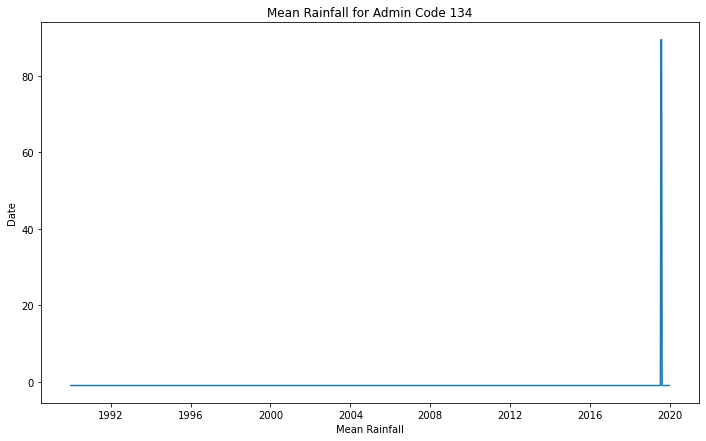

216


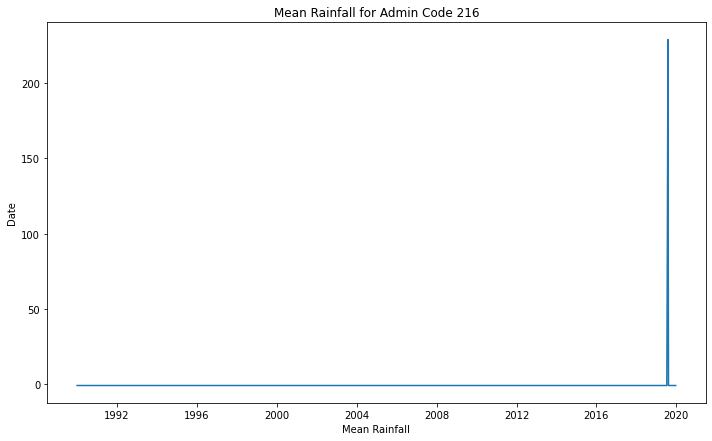

255


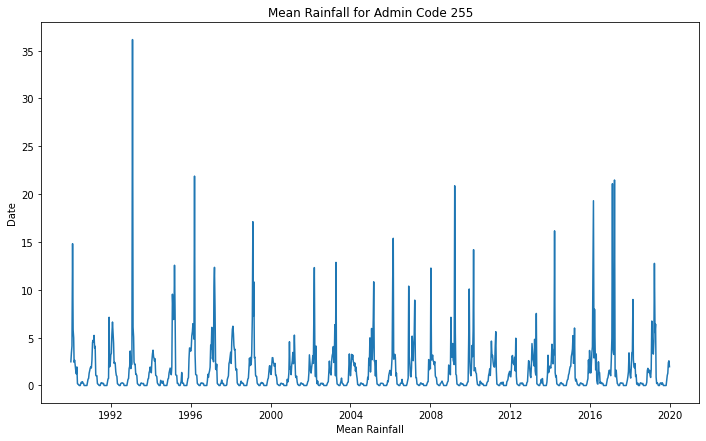

56


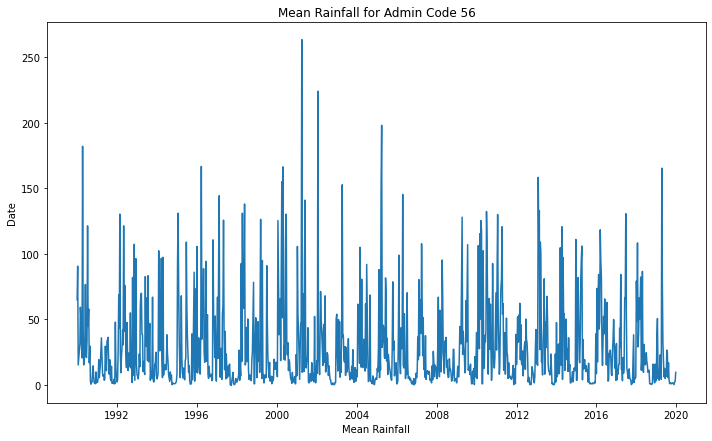

In [40]:
for code in data[data['mean_rainfall'] < 0]['AdminCode'].unique():
    print(code)
    plt.figure(figsize=(11.8, 7))
    plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] ==code]['mean_rainfall'])
    plt.title('Mean Rainfall for Admin Code {}'.format(code))
    plt.xlabel('Mean Rainfall')
    plt.ylabel('Date')
    plt.show()

##### Let's drop admin codes 134 and 216. Looks like bad data

In [41]:
data = data[~data['AdminCode'].isin([134, 216])]

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263460 entries, 0 to 265619
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   AdminCode      263460 non-null  int64         
 1   mean_rainfall  263460 non-null  float64       
 2   year           263460 non-null  int64         
 3   month          263460 non-null  int64         
 4   decade         263460 non-null  int64         
 5   day            263460 non-null  int64         
 6   date           263460 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 16.1 MB


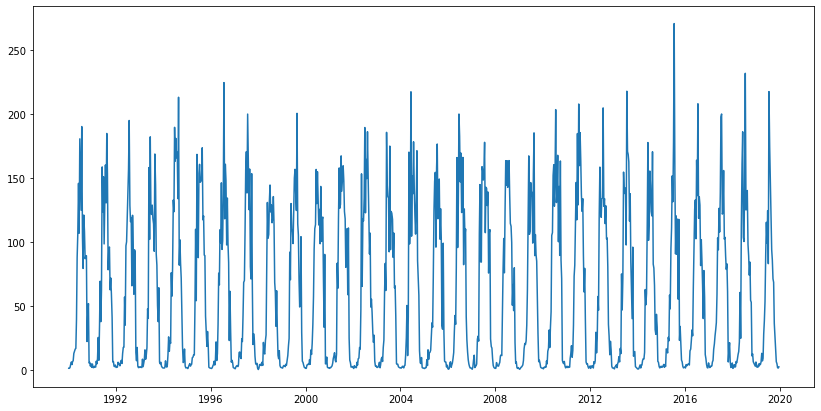

In [43]:
plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == 273]['date'], data[data['AdminCode'] == 273]['mean_rainfall'])
plt.show()

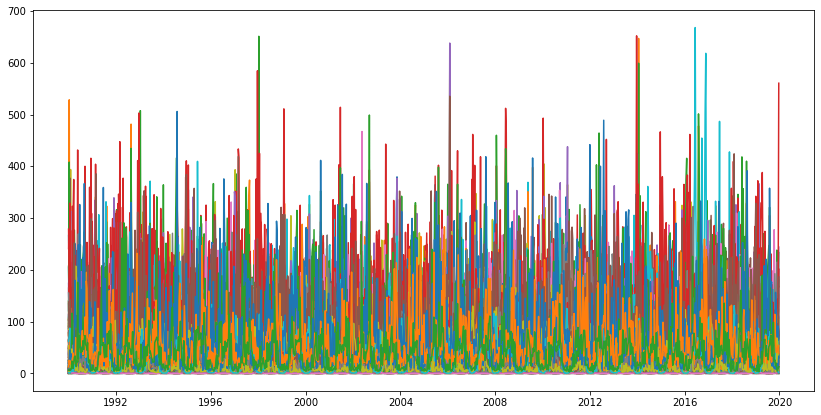

In [44]:
plt.figure(figsize=(14, 7))
for code in data['AdminCode'].unique():
    plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] == code]['mean_rainfall'])
plt.show()

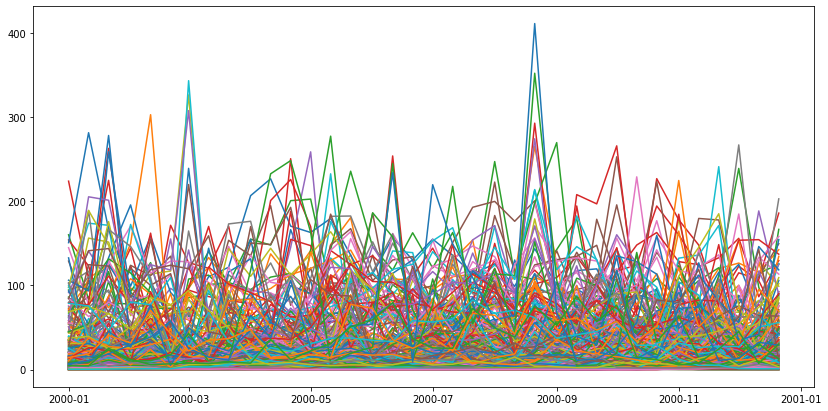

In [45]:
data2000 = data[data['date'].dt.year == 2000]
plt.figure(figsize=(14, 7))
for code in data2000['AdminCode'].unique():
    plt.plot(data2000[data2000['AdminCode'] == code]['date'], data2000[data2000['AdminCode'] == code]['mean_rainfall'])
plt.show()

### Build initial Prophet model

In [46]:
df = pd.DataFrame()
df['ds'] = data['date']
df['y'] = data['mean_rainfall']
# df['cap'] = 15000
df['floor'] = 0  # only used if growth='logistic'

In [47]:
code = 273

prophet = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  changepoint_prior_scale=.05
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=4,
                                    prior_scale=10,
                                    mode='additive'
                  )

In [48]:
prophet.fit(df[data['AdminCode'] == code])

In [49]:
future = prophet.make_future_dataframe(periods=31, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

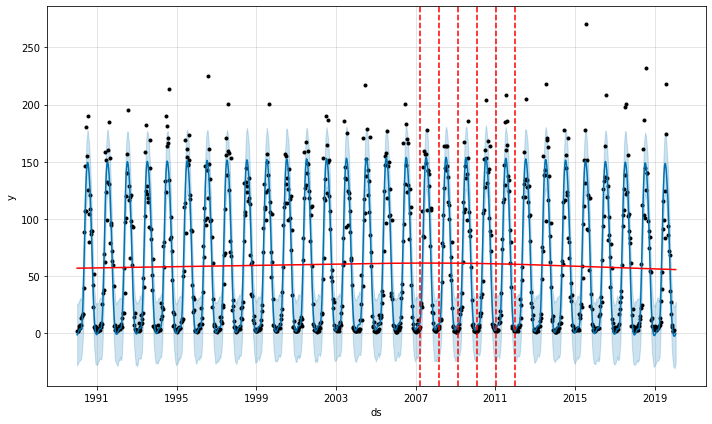

In [50]:
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

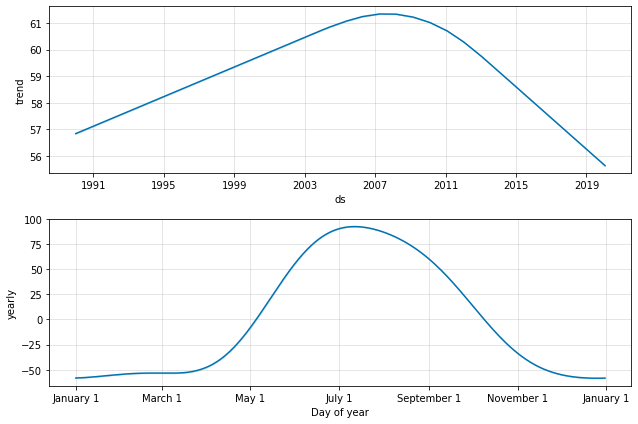

In [51]:
fig2 = prophet.plot_components(forecast)
plt.show()

In [52]:
cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))

In [53]:
len(cutoffs)

228

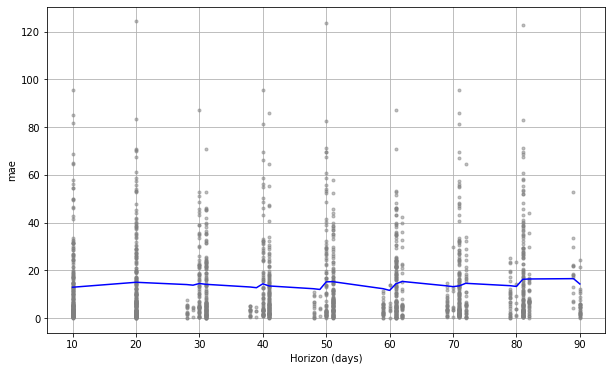

MAE: 13.94


In [54]:
df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '90 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()
print('MAE:', '{:.2f}'.format(df_p['mae'].mean()))

### Hyperparameter tuning

In [55]:
def run_model(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode):
    prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=changepoint_prior_scale
                     ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=fourier_order,
                                        prior_scale=prior_scale,
                                        mode=mode
                                        )
    
    prophet.fit(df[data['AdminCode'] == admin_code])
    
    future = prophet.make_future_dataframe(periods=31, freq='D')
    future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

    forecast = prophet.predict(future)
    
    cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))
    df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '31 days', cutoffs=cutoffs, parallel='processes')
    df_p = performance_metrics(df_cv)
    
    rmse = df_p['rmse'].mean()
    print('rmse:', '{:.2f}'.format(rmse))
    return rmse

### Grid search hyperparameters with random sample of admin codes

In [56]:
results = {}

admin_codes = random.sample(data['AdminCode'].unique().tolist(), 5)

changepoint_prior_scales = [.01, .05, .15]
fourier_orders = [4]
prior_scales = [1, 10, 30]
modes = ['multiplicative', 'additive']

for admin_code in admin_codes:
    results[admin_code] = []
    for changepoint_prior_scale in changepoint_prior_scales:
        for fourier_order in fourier_orders:
            for prior_scale in prior_scales:
                for mode in modes:
                    params = {'admin_code': admin_code,
                              'changepoint_prior_scale': changepoint_prior_scale,
                              'fourier_order': fourier_order,
                              'prior_scale': prior_scale,
                              'mode': mode}
#                     print(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    print(params)
#                     rmse = run_model(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    rmse = run_model(**params)
                    results[admin_code].append((rmse, params))
                    print()

{'admin_code': 260, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ed3c88>


rmse: 31.52

{'admin_code': 260, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd1d8278>


rmse: 31.69

{'admin_code': 260, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9afd7f0>


rmse: 31.49

{'admin_code': 260, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0ab780>


rmse: 31.71

{'admin_code': 260, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea5b1b70>


rmse: 31.48

{'admin_code': 260, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea6252e8>


rmse: 31.65

{'admin_code': 260, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9e63940>


rmse: 31.67

{'admin_code': 260, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ec3358>


rmse: 31.61

{'admin_code': 260, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea093390>


rmse: 31.70

{'admin_code': 260, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd1d8470>


rmse: 31.62

{'admin_code': 260, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea621630>


rmse: 31.68

{'admin_code': 260, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea185f28>


rmse: 31.61

{'admin_code': 260, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9e36320>


rmse: 31.80

{'admin_code': 260, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ec3358>


rmse: 31.69

{'admin_code': 260, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea185f28>


rmse: 31.80

{'admin_code': 260, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9e634e0>


rmse: 31.68

{'admin_code': 260, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0ee588>


rmse: 31.81

{'admin_code': 260, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ebf7b8>


rmse: 31.69

{'admin_code': 204, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ed4198>


rmse: 6.18

{'admin_code': 204, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea621630>


rmse: 6.15

{'admin_code': 204, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0ab780>


rmse: 6.19

{'admin_code': 204, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ed4080>


rmse: 6.15

{'admin_code': 204, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9f17a20>


rmse: 6.18

{'admin_code': 204, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea673358>


rmse: 6.15

{'admin_code': 204, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9afd908>


rmse: 6.17

{'admin_code': 204, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9e361d0>


rmse: 6.15

{'admin_code': 204, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ea6828>


rmse: 6.17

{'admin_code': 204, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd1d8080>


rmse: 6.15

{'admin_code': 204, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea5b1b70>


rmse: 6.17

{'admin_code': 204, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9f17d30>


rmse: 6.15

{'admin_code': 204, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9e0c550>


rmse: 6.21

{'admin_code': 204, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd3db358>


rmse: 6.18

{'admin_code': 204, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea5b1b70>


rmse: 6.21

{'admin_code': 204, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea5b1b70>


rmse: 6.18

{'admin_code': 204, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0ab780>


rmse: 6.20

{'admin_code': 204, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea54dd30>


rmse: 6.18

{'admin_code': 251, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ed4080>


rmse: 15.03

{'admin_code': 251, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea54dd30>


rmse: 15.04

{'admin_code': 251, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ea6dd8>


rmse: 15.08

{'admin_code': 251, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd327f28>


rmse: 15.06

{'admin_code': 251, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9e0c550>


rmse: 15.07

{'admin_code': 251, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea54dd30>


rmse: 15.06

{'admin_code': 251, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0ee1d0>


rmse: 15.14

{'admin_code': 251, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ebf7b8>


rmse: 15.08

{'admin_code': 251, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd169518>


rmse: 15.14

{'admin_code': 251, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd327e10>


rmse: 15.08

{'admin_code': 251, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ebf7b8>


rmse: 15.15

{'admin_code': 251, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ec3358>


rmse: 15.08

{'admin_code': 251, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9afd8d0>


rmse: 15.23

{'admin_code': 251, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9f08ef0>


rmse: 15.12

{'admin_code': 251, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ed38d0>


rmse: 15.23

{'admin_code': 251, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd1d8588>


rmse: 15.12

{'admin_code': 251, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9eebe10>


rmse: 15.23

{'admin_code': 251, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd3272e8>


rmse: 15.11

{'admin_code': 27, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9afd7f0>


rmse: 15.61

{'admin_code': 27, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea5b1b70>


rmse: 15.57

{'admin_code': 27, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea0e1f28>


rmse: 15.63

{'admin_code': 27, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ed4080>


rmse: 15.59

{'admin_code': 27, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd3365f8>


rmse: 15.60

{'admin_code': 27, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0fef60>


rmse: 15.57

{'admin_code': 27, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ebf7b8>


rmse: 15.60

{'admin_code': 27, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ec3898>


rmse: 15.59

{'admin_code': 27, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0fef60>


rmse: 15.60

{'admin_code': 27, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ea7be0>


rmse: 15.59

{'admin_code': 27, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd1d8588>


rmse: 15.60

{'admin_code': 27, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ebf7b8>


rmse: 15.59

{'admin_code': 27, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ec3898>


rmse: 15.65

{'admin_code': 27, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0ee1d0>


rmse: 15.63

{'admin_code': 27, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0ab780>


rmse: 15.65

{'admin_code': 27, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9f17d30>


rmse: 15.63

{'admin_code': 27, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea185f28>


rmse: 15.65

{'admin_code': 27, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea54d7b8>


rmse: 15.63

{'admin_code': 128, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd33d898>


rmse: 29.72

{'admin_code': 128, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea0e1f28>


rmse: 29.80

{'admin_code': 128, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9eaf860>


rmse: 29.69

{'admin_code': 128, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9eeb320>


rmse: 29.80

{'admin_code': 128, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ca8f28>


rmse: 29.71

{'admin_code': 128, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ea7be0>


rmse: 29.81

{'admin_code': 128, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea5d0ba8>


rmse: 29.10

{'admin_code': 128, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9eebe10>


rmse: 29.30

{'admin_code': 128, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea093390>


rmse: 29.10

{'admin_code': 128, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ec3358>


rmse: 29.29

{'admin_code': 128, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ebf7b8>


rmse: 29.11

{'admin_code': 128, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea621630>


rmse: 29.31

{'admin_code': 128, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd1d8080>


rmse: 28.85

{'admin_code': 128, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ec3358>


rmse: 29.04

{'admin_code': 128, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea54ddd8>


rmse: 28.85

{'admin_code': 128, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea5d0ef0>


rmse: 29.04

{'admin_code': 128, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9ebf7b8>


rmse: 28.84

{'admin_code': 128, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea54ddd8>


rmse: 29.02



In [57]:
for admin_code in results:
    best_model = sorted(results[admin_code], key=lambda x: x[0])[0]
    print(admin_code, 'best parameters:', best_model)

260 best parameters: (31.484342655013776, {'admin_code': 260, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'})
204 best parameters: (6.146023218780072, {'admin_code': 204, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'})
251 best parameters: (15.03393011188104, {'admin_code': 251, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 1, 'mode': 'multiplicative'})
27 best parameters: (15.57114703805771, {'admin_code': 27, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'})
128 best parameters: (28.843926706755763, {'admin_code': 128, 'changepoint_prior_scale': 0.15, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'})


In [58]:
for admin_code in results:
    print('{} RMSE: {:.2f}, mean rainfall: {:.2f}'.format(admin_code,
                                                          sorted(results[admin_code], key=lambda x: x[0])[0][0],
                                                          data[data['AdminCode'] == admin_code].groupby('AdminCode')['mean_rainfall'].mean().values[0]))

260 RMSE: 31.48, mean rainfall: 36.14
204 RMSE: 6.15, mean rainfall: 16.86
251 RMSE: 15.03, mean rainfall: 15.48
27 RMSE: 15.57, mean rainfall: 24.29
128 RMSE: 28.84, mean rainfall: 29.92


In [59]:
# Find most frequest best params per admin code
sorted_results = [sorted(results[admin_code], key=lambda x: x[0])[0][1] for admin_code in results]
best_params_list = [', '.join(str(x) for x in [value for key, value in {key: d[key] for key in d if key != 'admin_code'}.items()]) for d in sorted_results]
value, count = Counter(best_params_list).most_common(1)[0]
param_list = value.split(', ')
best_params = {'changepoint_prior_scale': float(param_list[0]),
               'fourier_order': int(param_list[1]),
               'prior_scale': int(param_list[2]),
               'mode': param_list[3]}
best_params

{'changepoint_prior_scale': 0.01,
 'fourier_order': 4,
 'mode': 'multiplicative',
 'prior_scale': 30}

In [ ]:
results = {}

admin_codes = random.sample(data['AdminCode'].unique().tolist(), 25)

changepoint_prior_scales = [.01]
fourier_orders = [4]
prior_scales = [30]
modes = ['multiplicative', 'additive']

for admin_code in admin_codes:
    results[admin_code] = []
    for changepoint_prior_scale in changepoint_prior_scales:
        for fourier_order in fourier_orders:
            for prior_scale in prior_scales:
                for mode in modes:
                    params = {'admin_code': admin_code,
                              'changepoint_prior_scale': changepoint_prior_scale,
                              'fourier_order': fourier_order,
                              'prior_scale': prior_scale,
                              'mode': mode}
#                     print(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    print(params)
#                     rmse = run_model(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    rmse = run_model(**params)
                    results[admin_code].append((rmse, params))
                    print()

{'admin_code': 28, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd1946d8>


rmse: 36.38

{'admin_code': 28, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0ee198>


rmse: 36.49

{'admin_code': 65, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd414eb8>


rmse: 10.28

{'admin_code': 65, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dda0fe1d0>


rmse: 10.28

{'admin_code': 79, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0de9da8a90>


rmse: 8.10

{'admin_code': 79, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dfccf4e48>


rmse: 8.13

{'admin_code': 213, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0de9da8a90>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 15.93

{'admin_code': 213, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0de9da8a90>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 15.94

{'admin_code': 211, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd286a58>


rmse: 32.74

{'admin_code': 211, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea54d7b8>


rmse: 32.55

{'admin_code': 40781, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9eeba90>


rmse: 8.39

{'admin_code': 40781, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0ddd2e9390>


rmse: 8.40

{'admin_code': 255, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dea54d7b8>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 2.09

{'admin_code': 255, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9f08b00>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 2.09

{'admin_code': 142, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0de9da8a90>


rmse: 12.84

{'admin_code': 142, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dd9eeba90>


rmse: 12.80

{'admin_code': 2647, 'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'prior_scale': 30, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dfccf4e48>


In [1]:
for admin_code in results:
    best_model = sorted(results[admin_code], key=lambda x: x[0])[0]
    print(admin_code, 'best parameters:', best_model)

NameError: ignored

In [ ]:
for admin_code in results:
    print('{} RMSE: {:.2f}, mean rainfall: {:.2f}'.format(admin_code,
                                                          sorted(results[admin_code], key=lambda x: x[0])[0][0],
                                                          data[data['AdminCode'] == admin_code].groupby('AdminCode')['mean_rainfall'].mean().values[0]))

In [ ]:
# Find most frequest best params per admin code
sorted_results = [sorted(results[admin_code], key=lambda x: x[0])[0][1] for admin_code in results]
best_params_list = [', '.join(str(x) for x in [value for key, value in {key: d[key] for key in d if key != 'admin_code'}.items()]) for d in sorted_results]
value, count = Counter(best_params_list).most_common(1)[0]
param_list = value.split(', ')
best_params = {'changepoint_prior_scale': float(param_list[0]),
               'fourier_order': int(param_list[1]),
               'prior_scale': int(param_list[2]),
               'mode': param_list[3]}
best_params

### Create forecasts for all admin codes

In [ ]:
def make_prophet_model(data, admin_code):
    
    data = data[data['AdminCode'] == admin_code]
    df = pd.DataFrame()
    df['ds'] = data['date']
    df['y'] = data['mean_rainfall']
    
    prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )
    prophet.fit(df[data['AdminCode'] == admin_code])
    
    return prophet

In [ ]:
forecast_df = pd.DataFrame(columns=['AdminCode', 'forecast_rainfall', 'year', 'month', 'decade'])

In [ ]:
models = {}

In [ ]:
cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))

In [ ]:
codes = data['AdminCode'].unique()
# codes = [code for idx, code in enumerate(codes) if idx % 5 == 0]  # for testing

counter = 0
total = len(codes)

for code in codes:
    if counter % 10 == 0:
        print('Processing {} / {}'.format(counter + 1, total))
    counter += 1
#     print()
#     print('Admin Code: {}'.format(code))
    # Make Prophet model
    prophet = make_prophet_model(data, code)
    
    # Make future DataFrame with 31 day forecast
    future = prophet.make_future_dataframe(periods=31, freq='D')
    # Remove all days except 01, 11, 21 (the "decades")
    future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]
    
    # Create forecast
    forecast = prophet.predict(future)
    
    # Plot forecast components
#     fig2 = prophet.plot_components(forecast)
#     plt.show()

    # Save the forecast for the next 3 decades
    output = pd.DataFrame(columns=['AdminCode', 'forecast_rainfall', 'year', 'month', 'decade'])
    output['forecast_rainfall'] = forecast.tail(3)['yhat'].clip(lower=0)
    output['forecast_rainfall_lower_ci'] = forecast.tail(3)['yhat_lower']
    output['forecast_rainfall_upper_ci'] = forecast.tail(3)['yhat_upper']
    output['year'] = forecast.tail(3)['ds'].dt.year
    output['month'] = forecast.tail(3)['ds'].dt.month
    output['decade'] = forecast.tail(3)['ds'].dt.day.astype(str).str.zfill(2).str[-2].astype(int) + 1
    output['AdminCode'] = code
    forecast_df = pd.concat([forecast_df, output])

    df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '31 days', cutoffs=cutoffs, parallel='processes')
    df_p = performance_metrics(df_cv)
#     fig = plot_cross_validation_metric(df_cv, metric='mae')
#     plt.show()
#     print('mae:', '{:.2f}%'.format(100 * df_p['mae'].mean()))
    models[code] = (df_p['rmse'].mean(), prophet, df_cv, df_p)

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F154C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B0838E888>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B070DD8C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B05DD99C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06ACB608>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06B08B88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06BEAE88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.proces

Processing 10 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B05E09148>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F72408>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06C19C88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F43808>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B068FC508>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B08385A88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A5A388>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06BDF188

Processing 20 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B0702F688>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B083A4988>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A5D7C8>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06AFFD08>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A61A48>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B05E0DAC8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F0BD88>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.proces

Processing 30 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B070533C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06907BC8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06C39A88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06C46B48>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B08394C88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F528C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B08345108>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B0838E5C8>
INFO:fbprophet:Skipping MAPE because y close to 

Processing 40 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F92488>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F01088>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06AFF448>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06BD3E88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06C2ED08>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B068CC548>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B08369D88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B070C22C8>
INFO:fbprophet:Skipping MAPE because y close to 

In [ ]:
# Admin code with lowest RMSE
[k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][0]

61013

In [ ]:
# Admin code with highest RMSE
[k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][-1]

2

In [ ]:
forecast_df

AdminCode  forecast_rainfall  year month decade  \
1078       273           0.873986  2020     1      1   
1079       273           1.644406  2020     1      2   
1080       273           2.831122  2020     1      3   
1078      1001           6.521660  2020     1      1   
1079      1001           6.396887  2020     1      2   
...        ...                ...   ...   ...    ...   
1081     40760           0.000000  2020     1      2   
1082     40760           0.000000  2020     1      3   
1080     61013           3.587077  2020     1      1   
1081     61013           1.364399  2020     1      2   
1082     61013           1.362681  2020     1      3   

      forecast_rainfall_lower_ci  forecast_rainfall_upper_ci  
1078                  -25.223359                   27.246085  
1079                  -25.622292                   29.284840  
1080                  -22.864223                   31.730558  
1078                  -21.389964                   35.224039  
1079                  -21.741275                   37.163822  
...                          ...                         ...  
1081                   -0.707104                    0.339332  
1082                   -0.713206                    0.382695  
1080                  -10.820152                   19.396063  
1081                  -12.778504                   16.855537  
1082                  -14.129120                   16.143237  

[147 rows x 7 columns]

In [ ]:
def find_middle(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return [input_list[int(middle - .5)]]
    else:
        return [input_list[int(middle)], input_list[int(middle-1)]]

In [ ]:
median_rainfall = find_middle(data.groupby('AdminCode')['mean_rainfall'].median().sort_values().index.tolist())
max_rainfall = [data.groupby('AdminCode')['mean_rainfall'].max().sort_values(ascending=False).index.tolist()[0],
                data.groupby('AdminCode')['mean_rainfall'].mean().sort_values(ascending=False).index.tolist()[0]]
min_rainfall = [data.groupby('AdminCode')['mean_rainfall'].min().sort_values(ascending=True).index.tolist()[0],
                data.groupby('AdminCode')['mean_rainfall'].mean().sort_values(ascending=True).index.tolist()[0]]

### View plots for 2 highest and 2 lowest RMSE admin codes, admin codes with highest, lowest, and median mean rainfall values, and an additional random sampling of 3 codes

Admin Code: 1


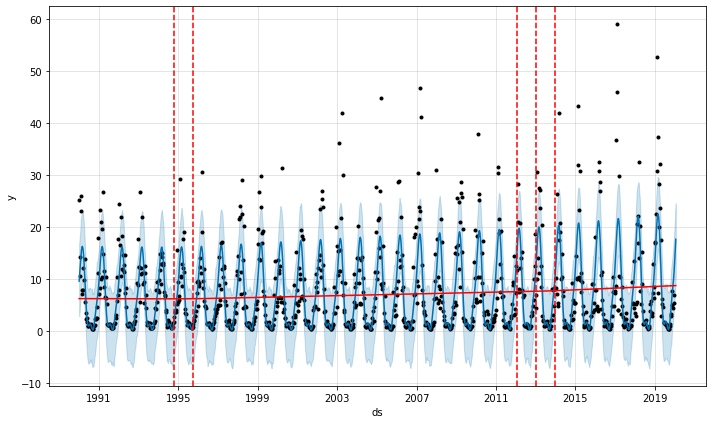

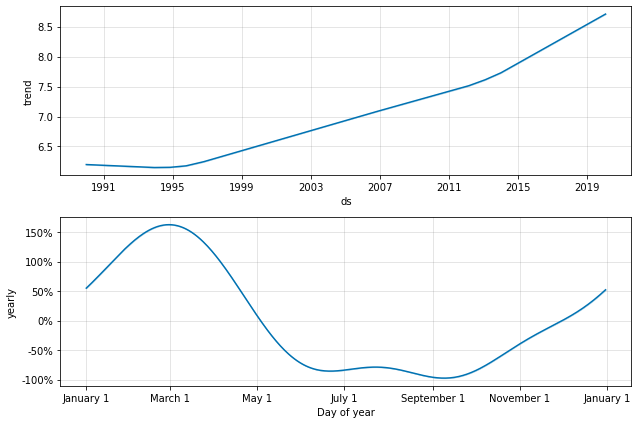

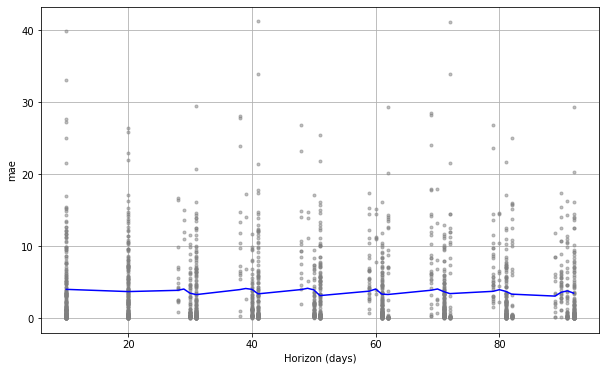

MAE: 368.05%


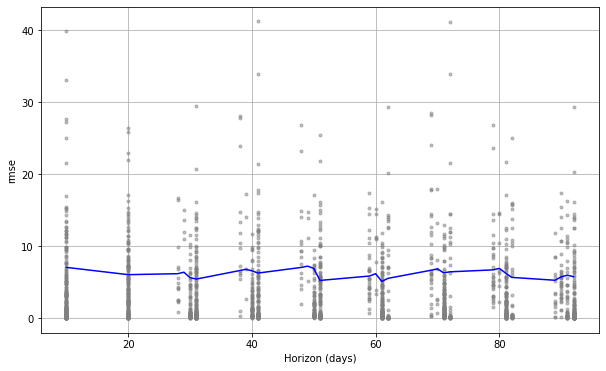

RMSE: 619.48%
Admin Code: 2


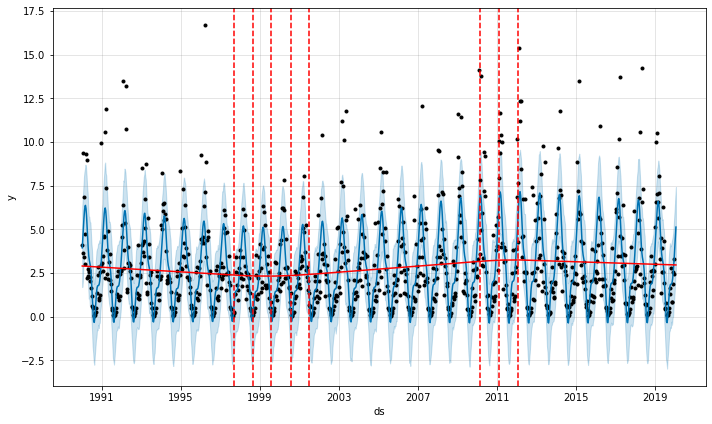

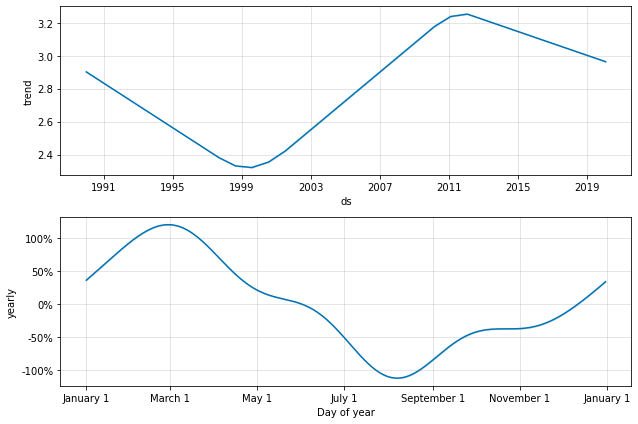

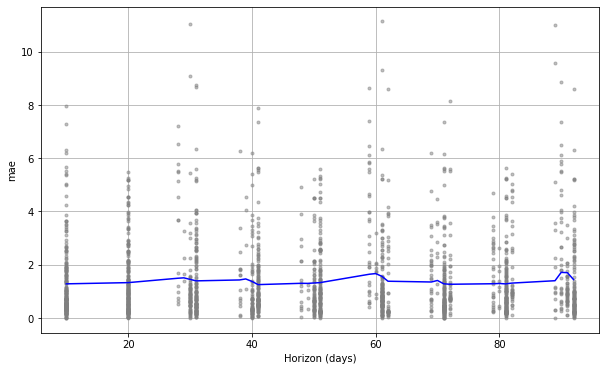

MAE: 140.73%


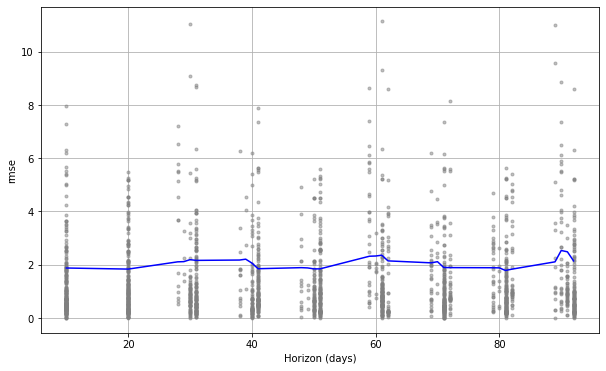

RMSE: 206.11%
Admin Code: 147299


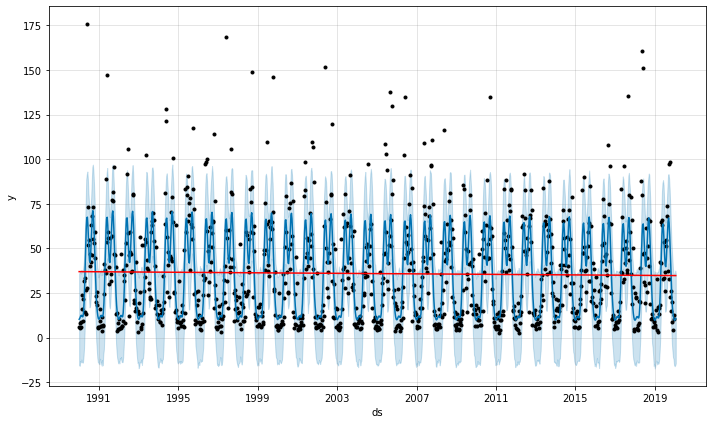

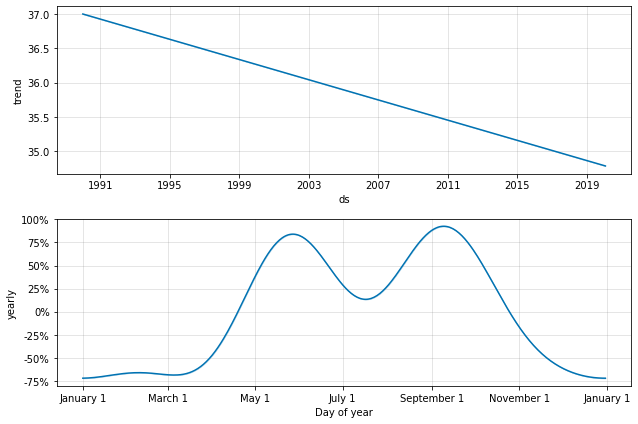

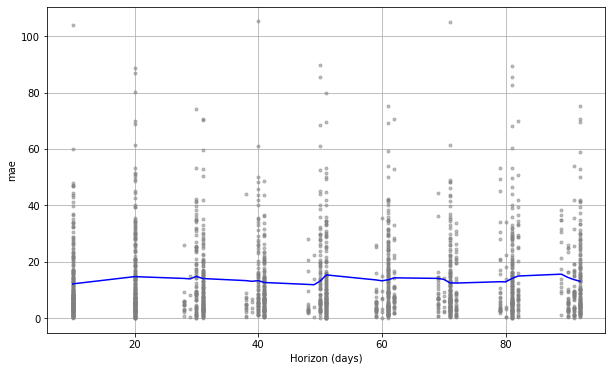

MAE: 1353.53%


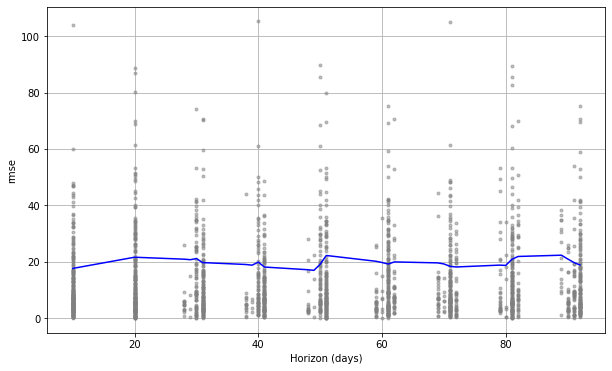

RMSE: 1960.57%
Admin Code: 134


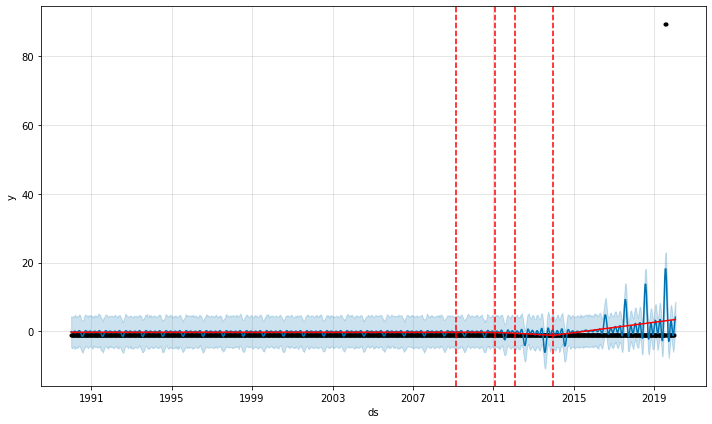

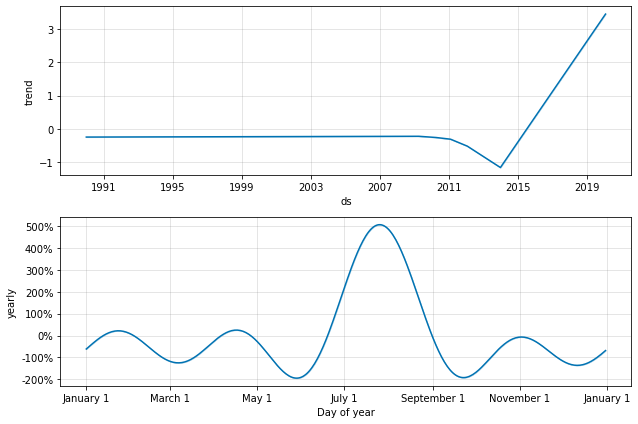

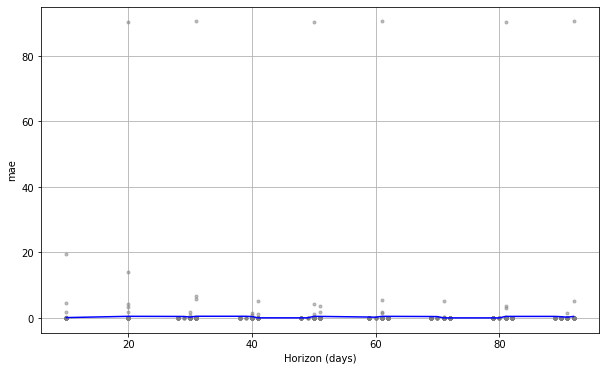

MAE: 32.95%


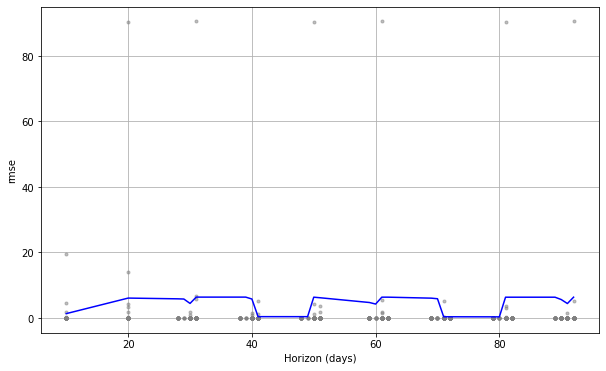

RMSE: 441.82%
Admin Code: 168


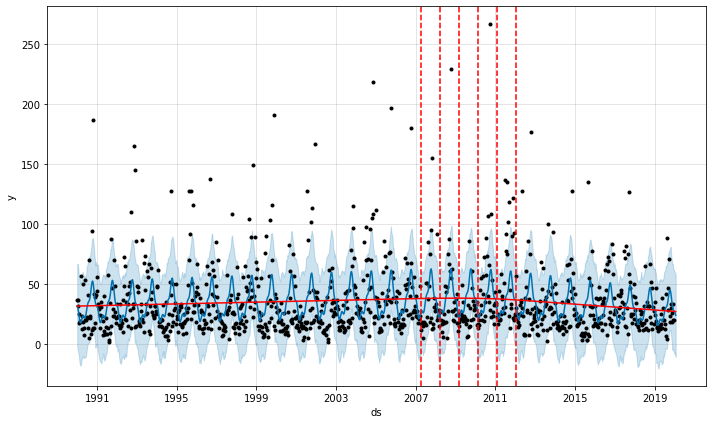

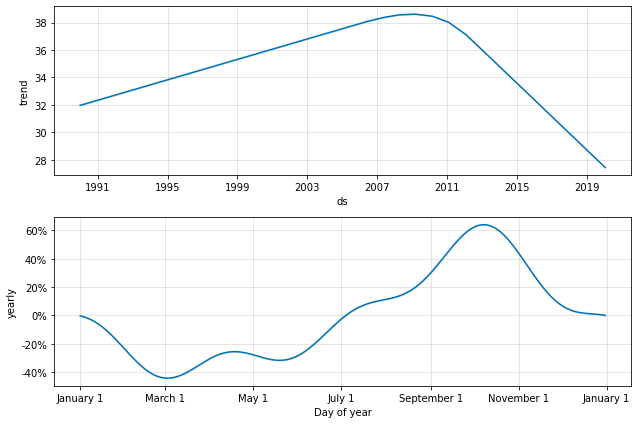

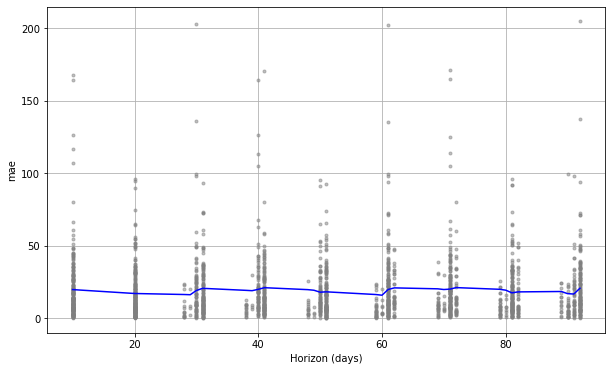

MAE: 1872.96%


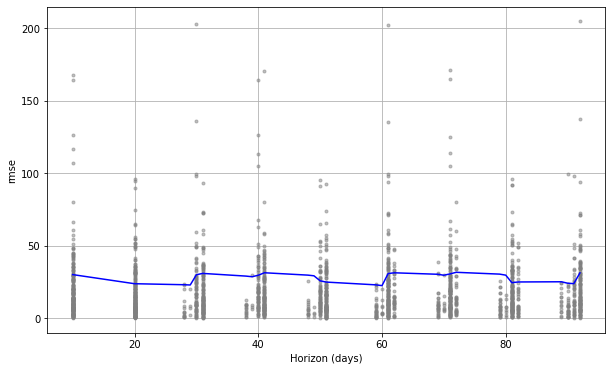

RMSE: 2765.72%
Admin Code: 233


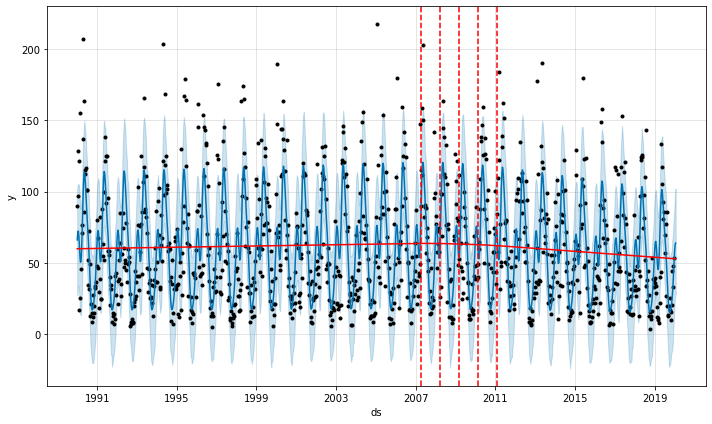

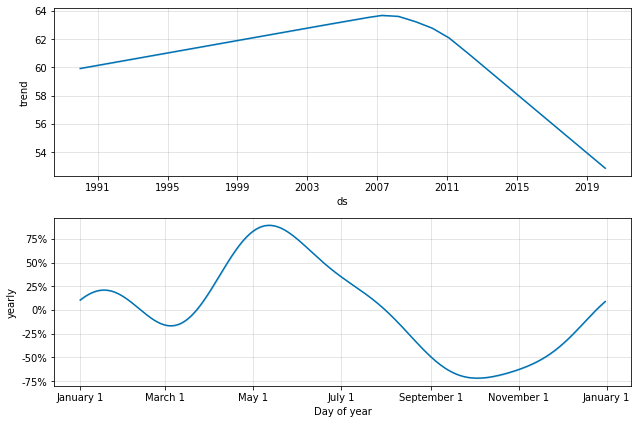

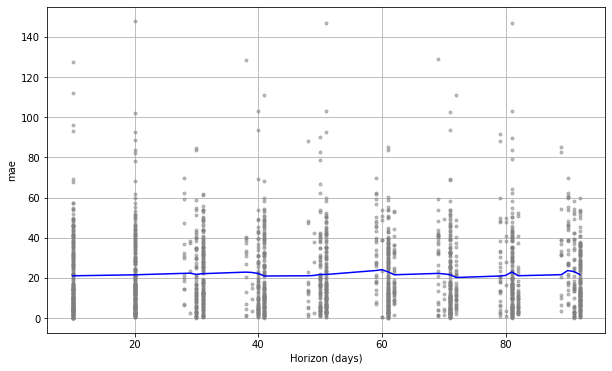

MAE: 2200.99%


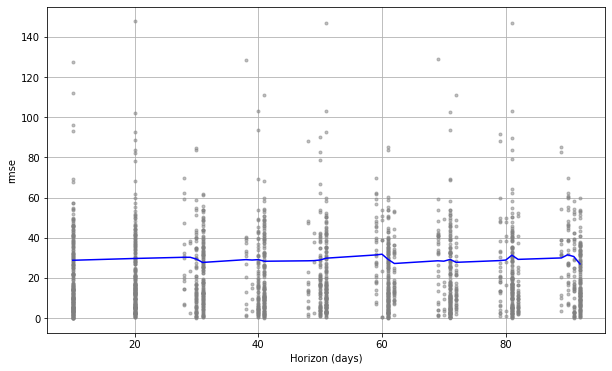

RMSE: 2926.09%
Admin Code: 148


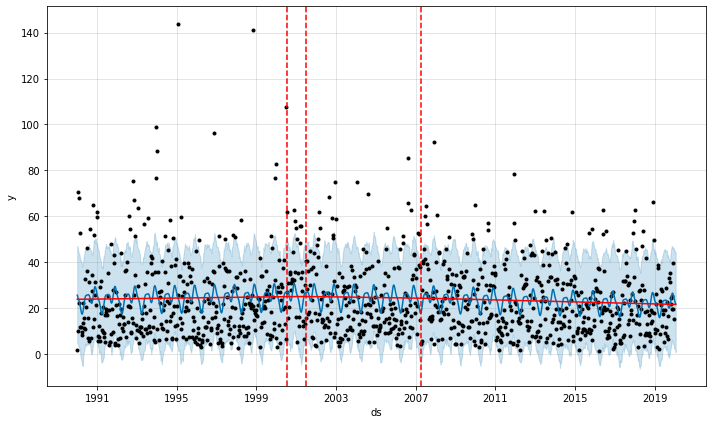

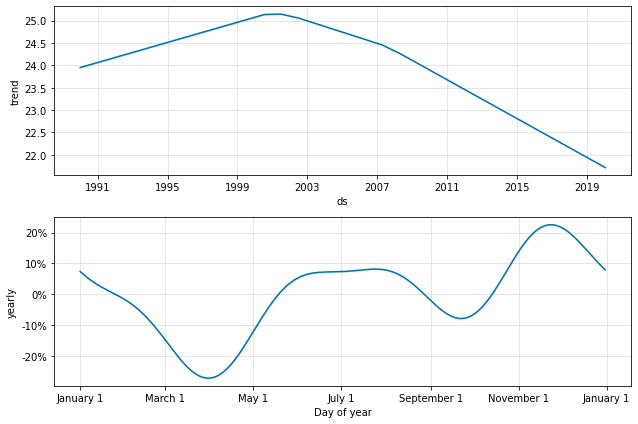

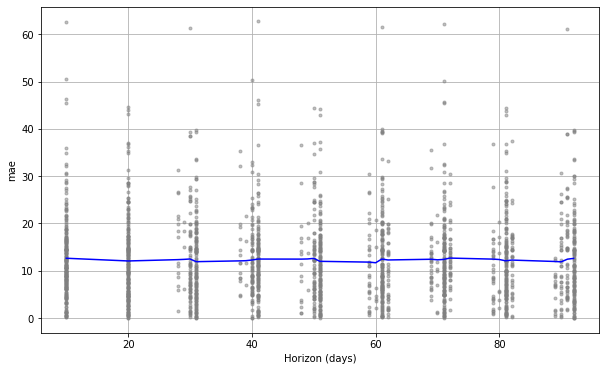

MAE: 1227.87%


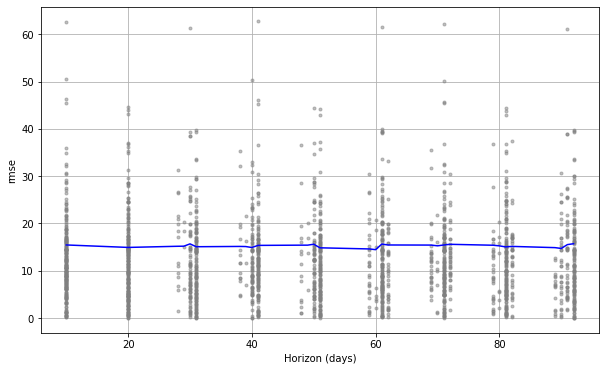

RMSE: 1522.51%
Admin Code: 61013


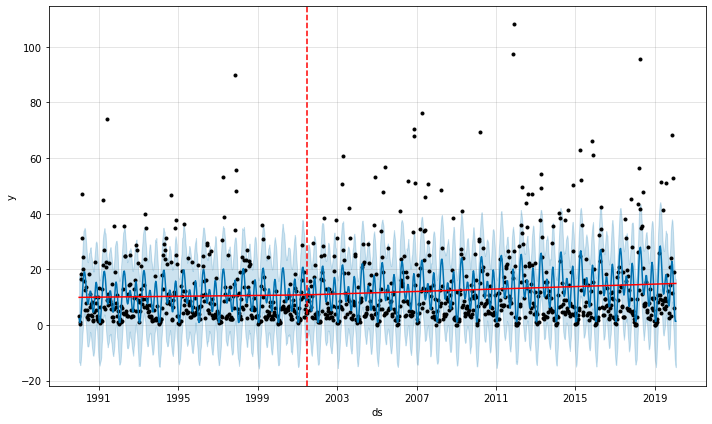

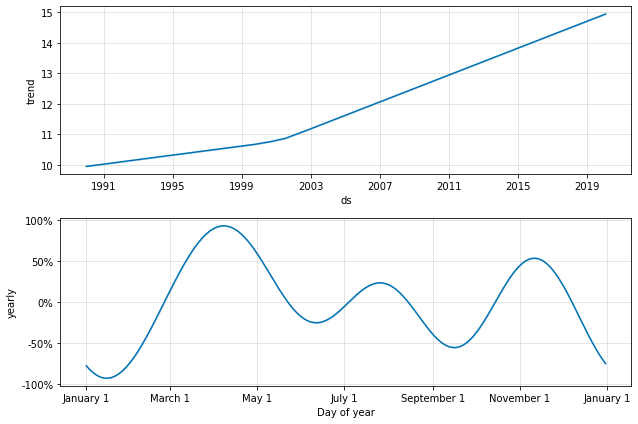

INFO:fbprophet:Skipping MAPE because y close to 0


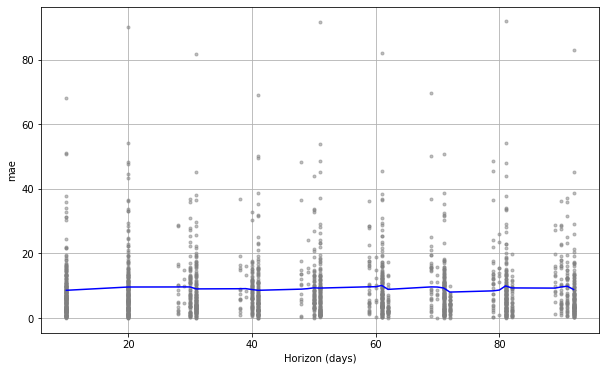

MAE: 923.06%


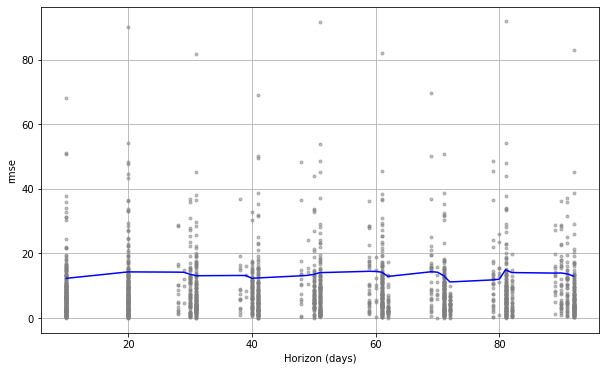

RMSE: 1342.02%
Admin Code: 54


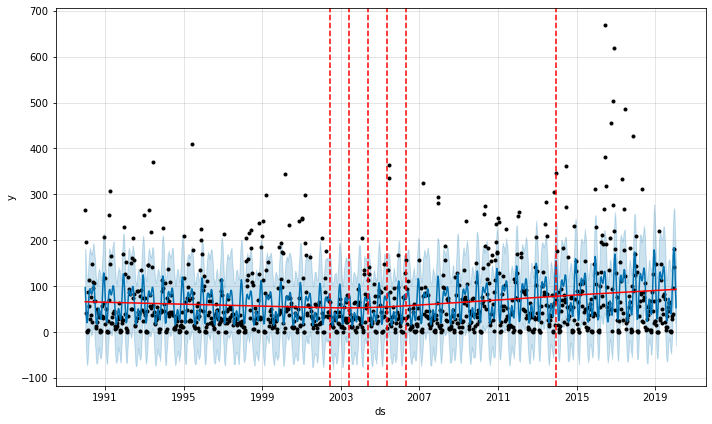

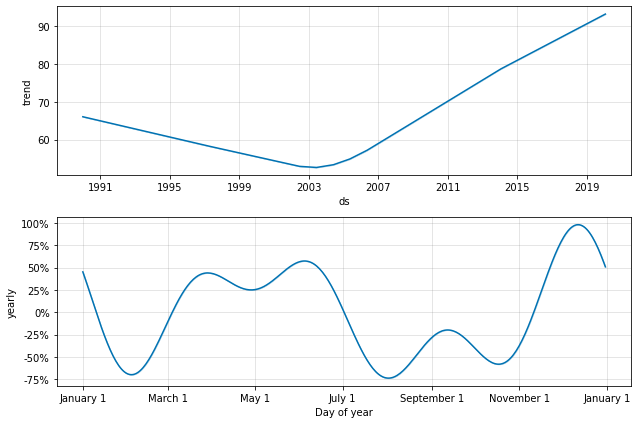

INFO:fbprophet:Skipping MAPE because y close to 0


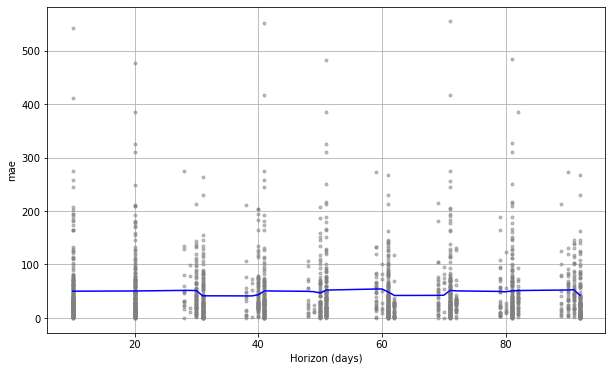

MAE: 4860.26%


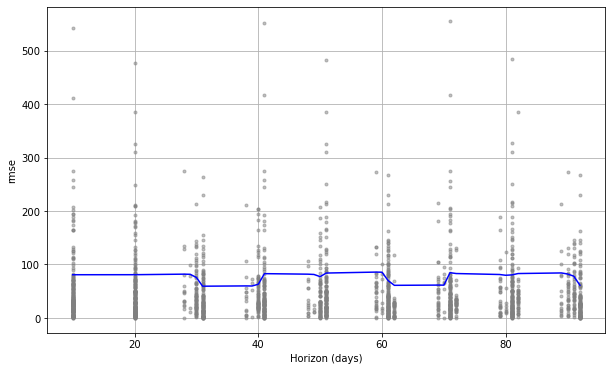

RMSE: 7581.73%
Admin Code: 216


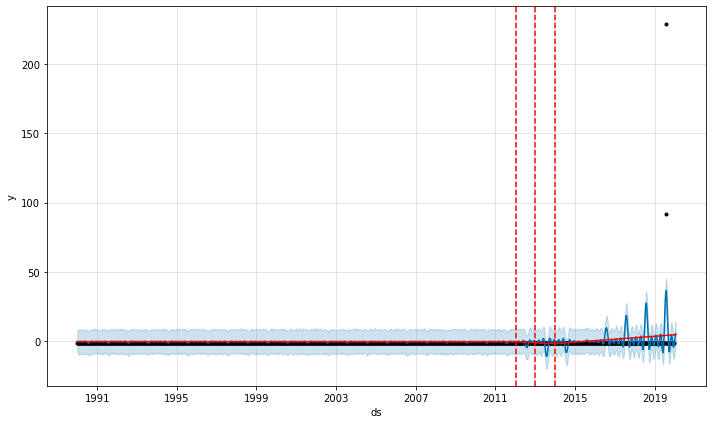

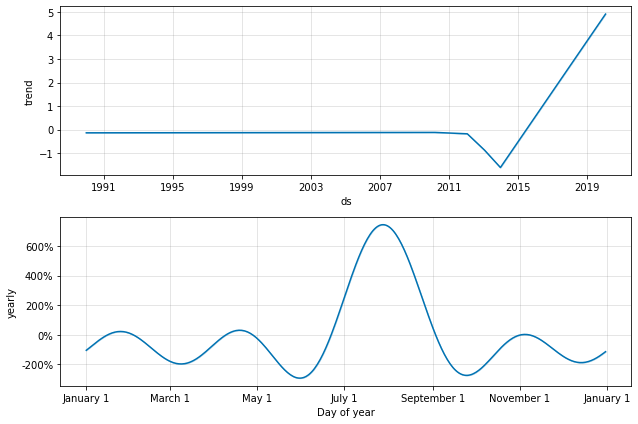

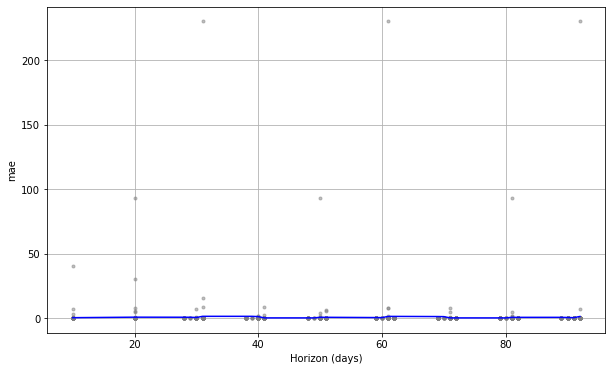

MAE: 57.16%


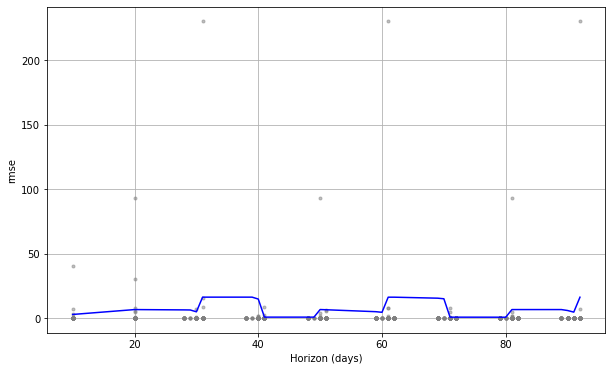

RMSE: 749.12%
Admin Code: 155


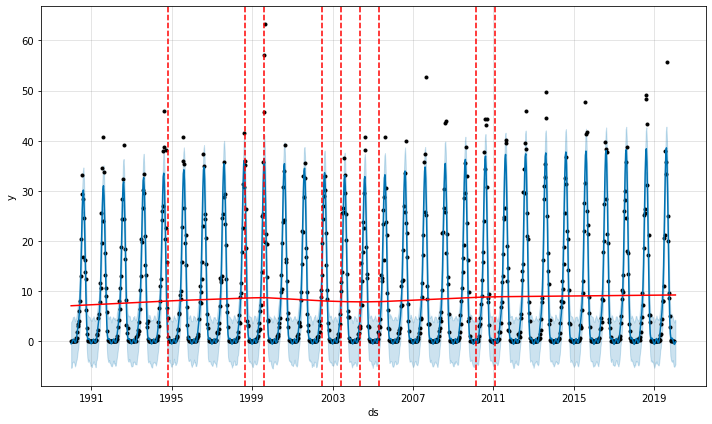

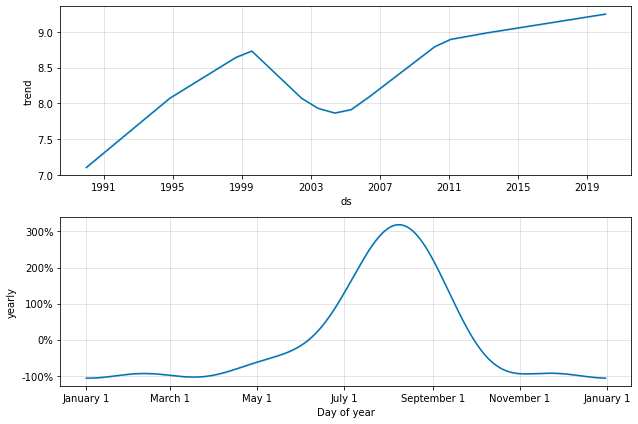

INFO:fbprophet:Skipping MAPE because y close to 0


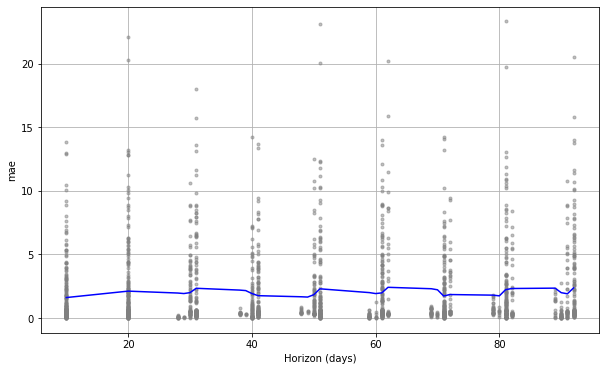

MAE: 201.58%


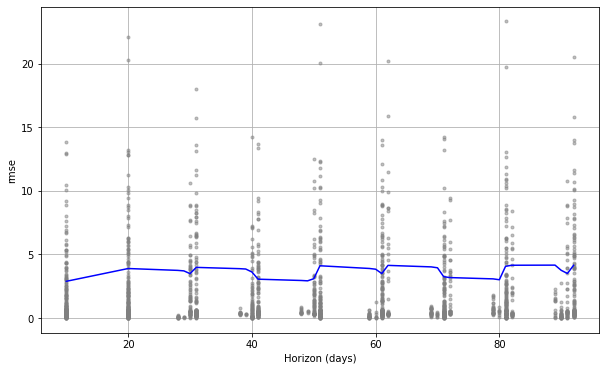

RMSE: 362.57%
Admin Code: 252


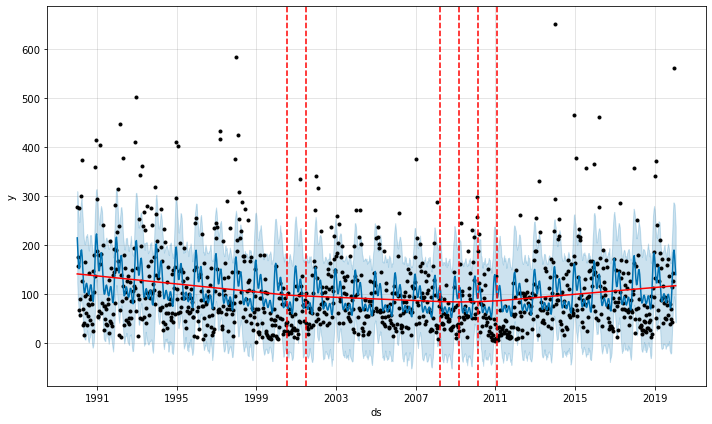

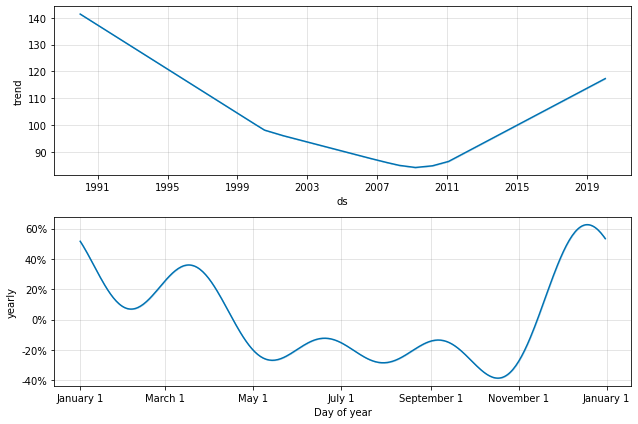

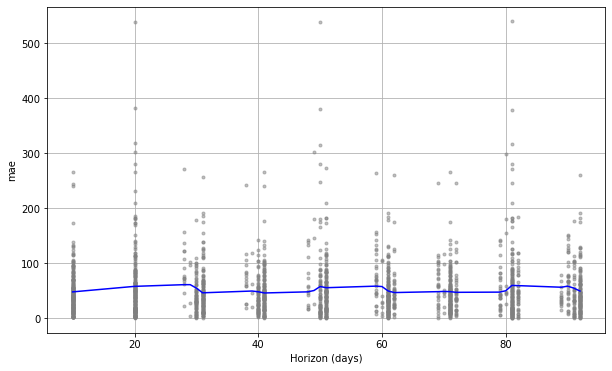

MAE: 5200.82%


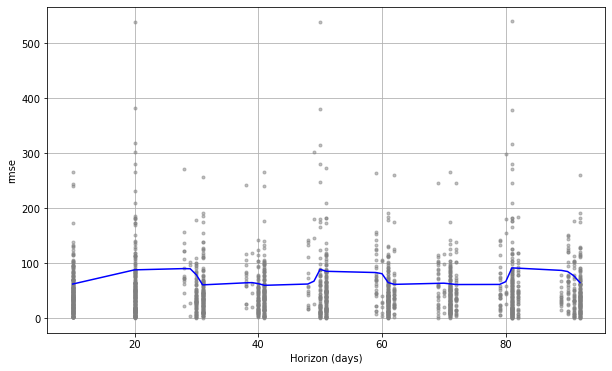

RMSE: 7264.47%


In [ ]:
for code in set([k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][:2] +
                [k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][-2:] +
                max_rainfall +
                min_rainfall +
                median_rainfall +
                random.sample(data['AdminCode'].unique().tolist(), 3)):
    print('Admin Code: {}'.format(code))
    
    plt.figure(figsize=(14, 7))
    plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] ==code]['mean_rainfall'])
    plt.title('Mean Rainfall for Admin Code {}'.format(code))
    plt.show()
    
    df = pd.DataFrame()
    df['ds'] = data[data['AdminCode'] == code]['date']
    df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

    prophet = Prophet(growth='linear',
                          yearly_seasonality=False,
                          weekly_seasonality=False,
                          daily_seasonality=False,
                          changepoint_prior_scale=.05,
                          mcmc_samples=0
                          ).add_seasonality(name='yearly',
                                            period=365.25,
                                            fourier_order=4,
                                            prior_scale=10,
                                            mode='multiplicative'
                          )

    prophet.fit(df)

    future = prophet.make_future_dataframe(periods=31, freq='D')
    future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

    forecast = prophet.predict(future)
    fig = prophet.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
    plt.show()

    fig2 = prophet.plot_components(forecast)
    plt.show()

    df_cv = cross_validation(prophet, horizon = '93 days', period='365 days', initial='3652 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mae')
    plt.show()
    print('MAE:', '{:.2f}'.format(df_p['mae'].mean()))
    fig = plot_cross_validation_metric(df_cv, metric='rmse')
    plt.show()
    print('RMSE:', '{:.2f}'.format(df_p['rmse'].mean()))
    print('====================================================================')

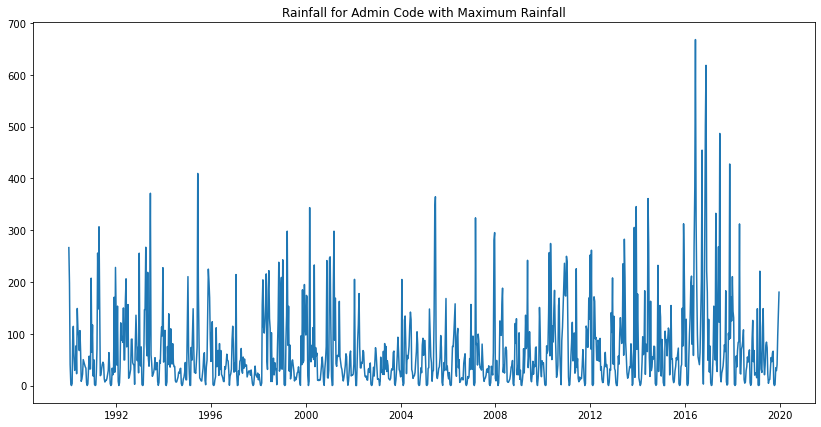

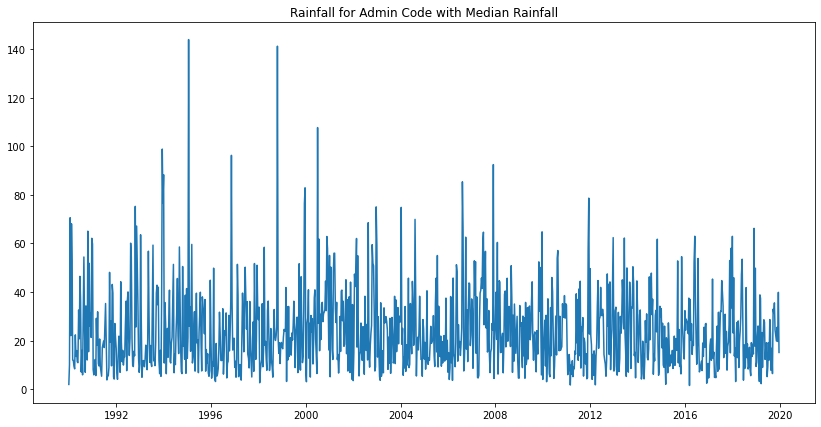

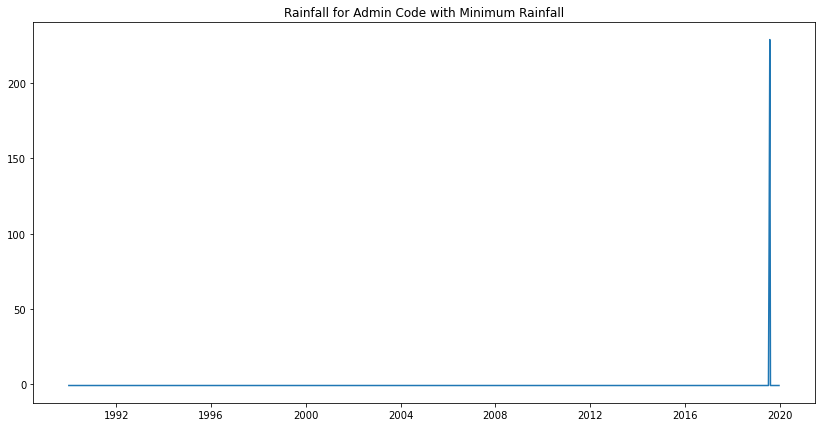

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == max_rainfall[0]]['date'], data[data['AdminCode'] == max_rainfall[0]]['mean_rainfall'])
plt.title('Rainfall for Admin Code with Maximum Rainfall')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == median_rainfall_admin_code[0]]['date'], data[data['AdminCode'] == median_rainfall_admin_code[0]]['mean_rainfall'])
plt.title('Rainfall for Admin Code with Median Rainfall')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == min_rainfall[0]]['date'], data[data['AdminCode'] == min_rainfall[0]]['mean_rainfall'])
plt.title('Rainfall for Admin Code with Minimum Rainfall')
plt.show()

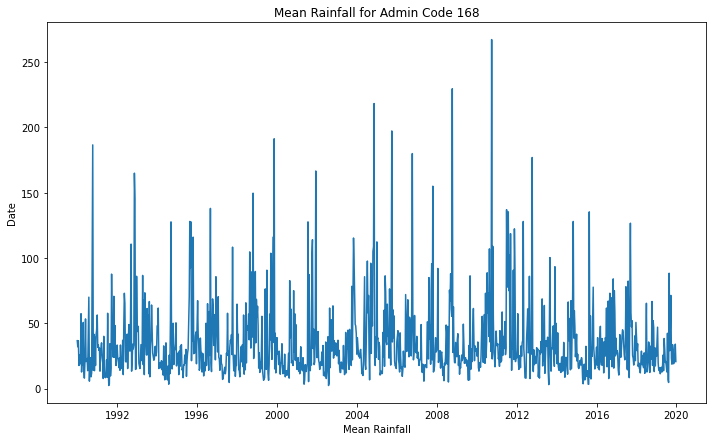

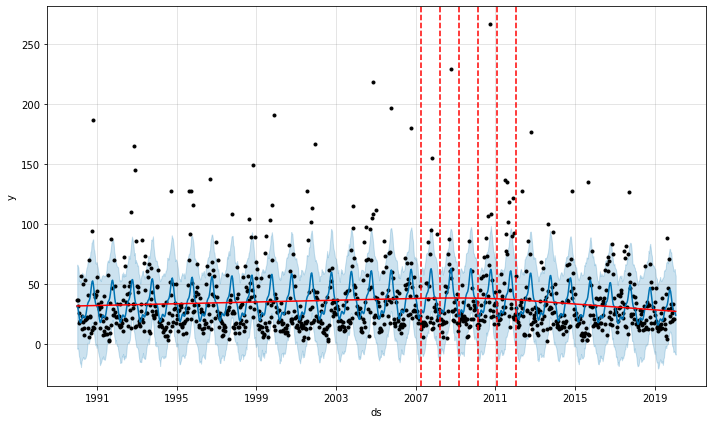

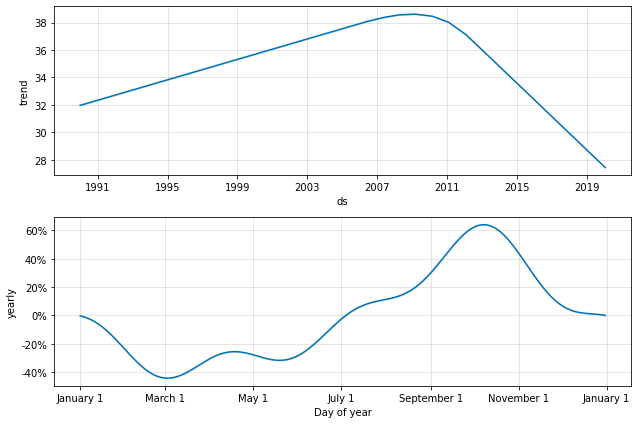

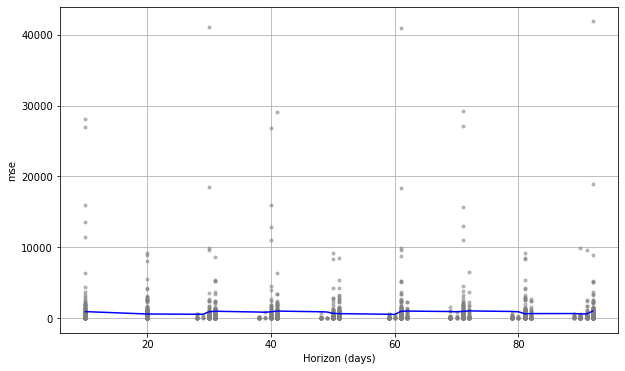

MSE: 77494.92%


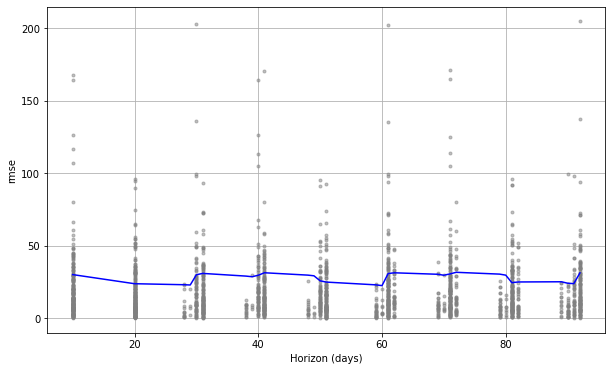

RMSE: 2765.72%


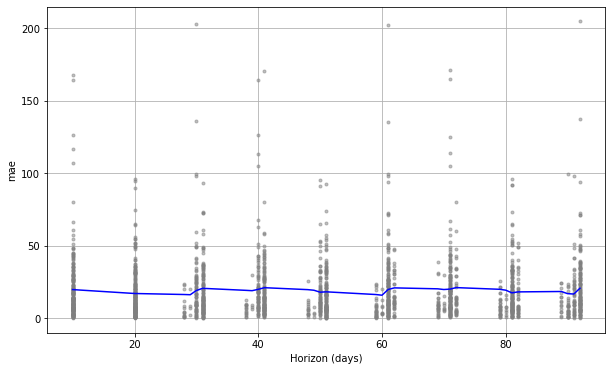

MAE: 1872.96%


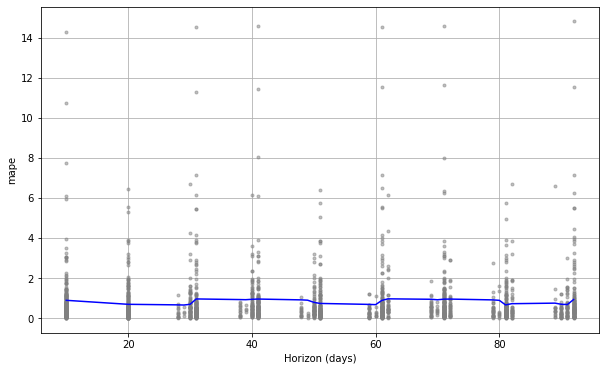

MAPE: 82.13%


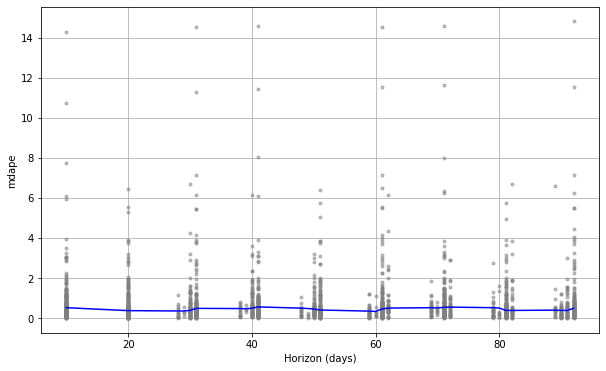

MDAPE: 44.55%


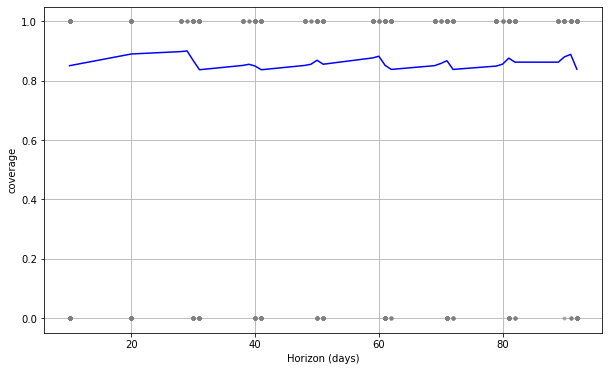

COVERAGE: 86.18%


In [ ]:
code = 168
    
plt.figure(figsize=(11.8, 7))
plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] ==code]['mean_rainfall'])
plt.title('Mean Rainfall for Admin Code {}'.format(code))
plt.xlabel('Mean Rainfall')
plt.ylabel('Date')
plt.show()

df = pd.DataFrame()
df['ds'] = data[data['AdminCode'] == code]['date']
df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )

prophet.fit(df)

future = prophet.make_future_dataframe(periods=31, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

fig2 = prophet.plot_components(forecast)
plt.show()

df_cv = cross_validation(prophet, horizon = '93 days', period='365 days', initial='3652 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)

for metric in ['mse', 'rmse', 'mae', 'mape', 'mdape', 'coverage']:
    fig = plot_cross_validation_metric(df_cv, metric=metric)
    plt.show()
    print('{}: {:.2f}'.format(metric.upper(), df_p[metric].mean()))

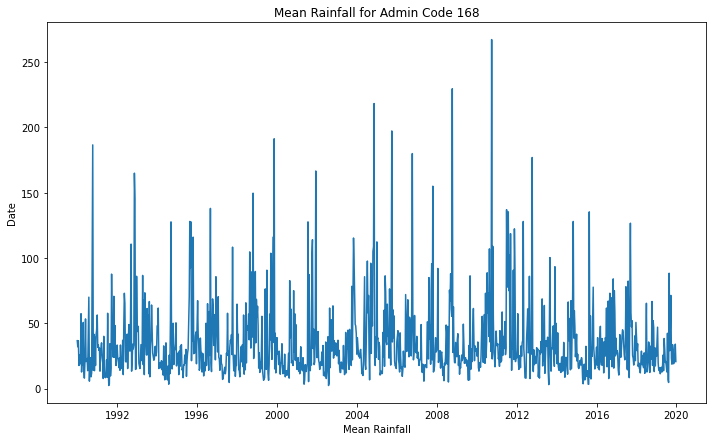

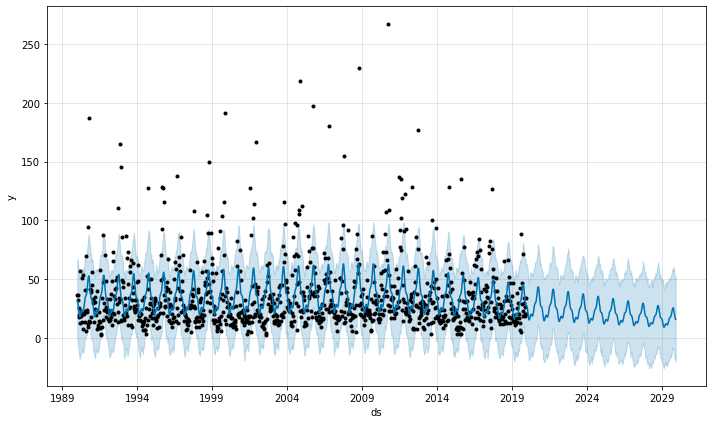

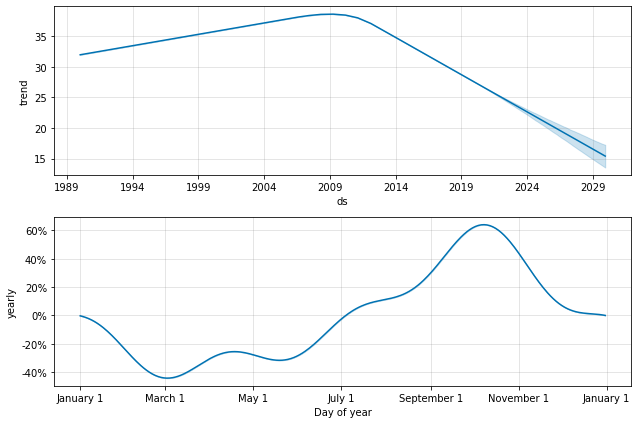

In [ ]:
code = 168
    
plt.figure(figsize=(11.8, 7))
plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] ==code]['mean_rainfall'])
plt.title('Mean Rainfall for Admin Code {}'.format(code))
plt.xlabel('Mean Rainfall')
plt.ylabel('Date')
plt.show()

df = pd.DataFrame()
df['ds'] = data[data['AdminCode'] == code]['date']
df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )

prophet.fit(df)

future = prophet.make_future_dataframe(periods=3652, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

fig2 = prophet.plot_components(forecast)
plt.show()